# Main analysis file

We load up one large dataframe consisting of all simulation sweeps and curves, produced by [src/get_all_data.py](../get_all_data.py).

In [268]:
import hydra
import torch

import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

## Load main dataframe

In [269]:
all_data_fp = "../../analysis_data/all_data.csv"

In [270]:
df = pd.read_csv(all_data_fp)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,1.520659e+00,1.271088e+00,0.640940,2.303956,0.001381,-0.00246,1.121848,0.0,simulation,NaN,...,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,-8.0,42.0,NaN
1,0.000000e+00,9.536743e-07,1.912027,16.400000,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,-8.0,42.0,NaN
2,0.000000e+00,9.536743e-07,1.912027,16.400000,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,-8.0,42.0,NaN
3,0.000000e+00,4.768372e-07,1.912027,16.400000,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,-8.0,42.0,NaN
4,4.768372e-07,9.536743e-07,1.912027,16.400000,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,-8.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31155,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
31156,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
31157,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
31158,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


## Set parameters for one theoretical bound

Using hydra compose overrides.

In [272]:
overrides = [
    "game.universe=c1",

    # "game.universe=100",
    # "game.num_signals=100",

    # "game.universe=2ball_300",
    # "game.num_signals=300",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

In [273]:
def get_df_subsetted_by_bound(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & bound_func]

    return df_subsetted

### Subset dataframes for plotting

In [274]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
202,4.768372e-07,0.000000,1.868035,6.313385,-4.452686,-0.000085,0.386164,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,3.0,42.0,NaN
203,2.084962e+00,0.695380,1.172655,5.089300,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,3.0,42.0,NaN
204,4.611731e-02,0.038187,1.829848,6.150680,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,3.0,42.0,NaN
205,9.005547e-03,0.007496,1.860539,6.281002,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,3.0,42.0,NaN
206,1.979351e-03,0.001649,1.866386,6.306237,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,3.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21678,3.584961e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
21679,3.584962e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
21680,3.584961e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
21681,3.584962e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


In [275]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

### Plot

#### Trade-offs

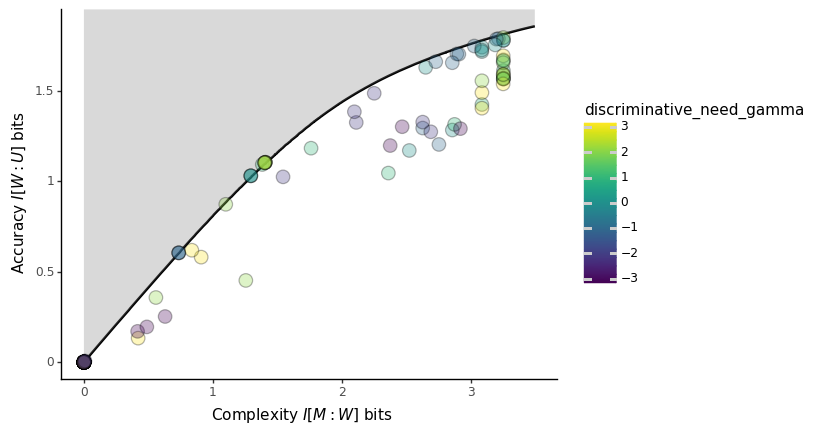

In [297]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

##### Hold two of { discriminative_need, imprecise_imitation, population_init } fixed and vary the other

In [289]:
df_fixed = df_final_points[df_final_points["imprecise_imitation_gamma"] == 0.]
df_fixed = df_fixed[df_fixed["population_init_gamma"] == -3.]
df_fixed

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
5983,1.293652,1.029609e+00,0.838426,2.629383,0.015704,-0.000537,0.998679,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
6074,1.401922,1.101795e+00,0.766240,2.447687,0.009238,0.000773,1.041955,0.0,simulation,NaN,...,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
6276,0.734831,6.040821e-01,1.263953,3.979443,0.021126,-0.005796,0.895484,0.0,simulation,NaN,...,-8,10,squared_dist,-1.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
6472,0.000000,0.000000e+00,1.868035,6.313385,-7.524890,-0.000088,0.386164,0.0,simulation,NaN,...,-8,10,squared_dist,-3.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
6515,1.401963,1.101983e+00,0.766052,2.446453,0.008417,0.000632,1.041955,0.0,simulation,NaN,...,-8,10,squared_dist,3.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
6717,1.399727,1.100716e+00,0.767320,2.448488,0.009096,-0.000298,1.041955,0.0,simulation,NaN,...,-8,10,squared_dist,2.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
6919,0.000000,4.768372e-07,1.868034,6.313385,-7.930835,-0.000089,0.386164,0.0,simulation,NaN,...,-8,10,squared_dist,-2.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN


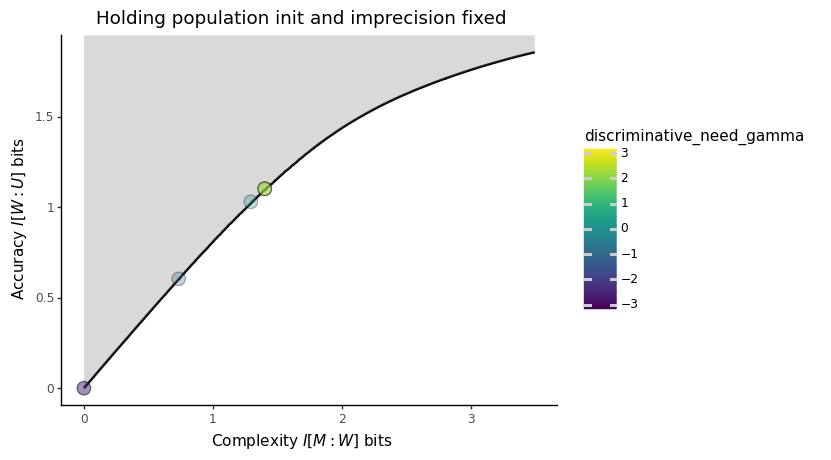

In [290]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_fixed,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
    + pn.ggtitle(f"Holding population init and imprecision fixed")
)
print(plot)

In [291]:
df_fixed = df_final_points[df_final_points["imprecise_imitation_gamma"] == 0.]
df_fixed = df_fixed[df_fixed["discriminative_need_gamma"] == 0.]
df_fixed

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
3950,1.293651,1.029609,0.838426,2.629383,0.015703,-0.000536,0.998679,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,3.0,42.0,NaN
4833,1.293651,1.029610,0.838426,2.629383,0.015704,-0.000537,0.998679,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,0.0,42.0,NaN
5983,1.293652,1.029609,0.838426,2.629383,0.015704,-0.000537,0.998679,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN


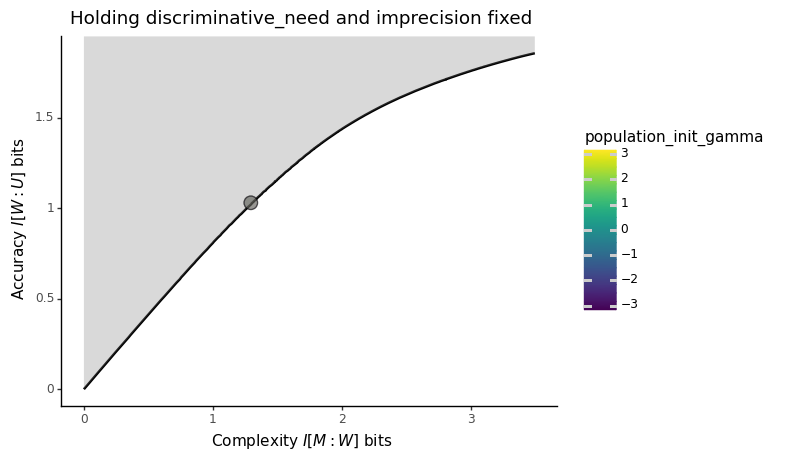

In [292]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_fixed,
        mapping=pn.aes(
            fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
    + pn.ggtitle(f"Holding discriminative need and imprecision fixed")
)
print(plot)

In [294]:
df_fixed = df_final_points[df_final_points["population_init_gamma"] == 0.]
df_fixed = df_fixed[df_fixed["discriminative_need_gamma"] == 0.]
df_fixed

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
330,0.000000,0.000000,1.868035,6.313385,1.000000,-0.327861,5.000000,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,0.0,42.0,NaN
752,3.251585,1.777412,0.090623,1.211285,0.051165,-0.019465,4.164450,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,3.0,0.0,42.0,NaN
2184,3.251609,1.777412,0.090622,1.211285,0.051249,-0.019460,4.164450,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,2.0,0.0,42.0,NaN
3744,0.000000,0.000000,1.868036,6.313385,1.000000,-0.327861,5.000000,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-2.0,0.0,42.0,NaN
3874,0.000000,0.000000,1.868035,6.313385,1.000000,-0.327861,5.000000,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-3.0,0.0,42.0,NaN
4833,1.293651,1.029610,0.838426,2.629383,0.015704,-0.000537,0.998679,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,0.0,42.0,NaN
8385,3.187032,1.752420,0.115615,1.267233,0.056153,-0.012266,3.741681,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,1.0,0.0,42.0,NaN


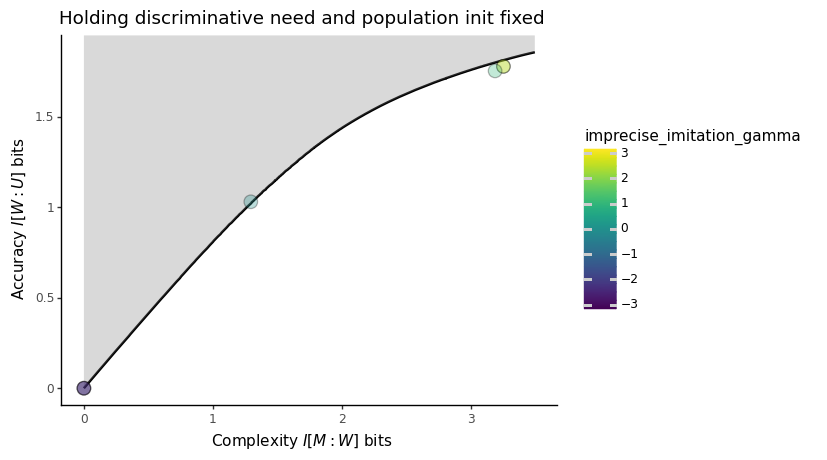

In [295]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_fixed,
        mapping=pn.aes(
            fill="imprecise_imitation_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
    + pn.ggtitle(f"Holding discriminative need and population init fixed")
)
print(plot)

#### Meaning distributions

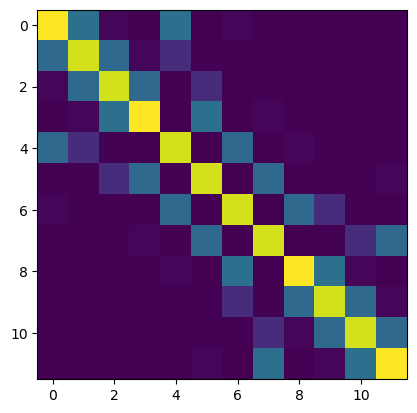

In [293]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)